## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer_" + str(i+1))(input_layer)
            x = BatchNormalization()(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer_" + str(i+1))(x)
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25, 0.5]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=reduce_factor, patient=reduce_patient, verbose=1, min_lr=1e-12)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    if i//4 == 0:
        exp_name_tag = ("%s SGD: factor-%s, patient-%s" % (i, str(reduce_factor), str(reduce_patient)))
    elif i//4 == 1:
        exp_name_tag = ("%s Adam: factor-%s, patient-%s" % (i, str(reduce_factor), str(reduce_patient)))
    elif i//4 == 2:
        exp_name_tag = ("%s RMSProp: factor-%s, patient-%s" % (i, str(reduce_factor), str(reduce_patient)))
        
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0729 14:44:06.920383  4600 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 14:44:06.921386  4600 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 14:44:06.922350  4600 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 14:44:06.965317  4600 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0729 14:44:07.075437  4600 deprecation_wr

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

W0729 14:44:07.143850  4600 deprecation.py:323] From D:\Anaconda3\envs\keras37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 54us/step - loss: 2.2375 - acc: 0.2693 - val_loss: 2.2583 - val_acc: 0.3050
Epoch 2/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.7639 - acc: 0.3887 - val_loss: 1.8280 - val_acc: 0.3721
Epoch 3/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.6319 - acc: 0.4317 - val_loss: 1.7225 - val_acc: 0.4090
Epoch 4/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.5553 - acc: 0.4579 - val_loss: 1.6508 - val_acc: 0.4239
Epoch 5/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.4965 - acc: 0.4784 - val_loss: 1.5937 - val_acc: 0.4459
Epoch 6/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.4533 - acc: 0.4953 - val_loss: 1.5585 - val_acc: 0.4615
Epoch 7/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.4160 - acc: 0.5069 - val_loss: 1.5540 - val_acc

50000/50000 [==============================] - 1s 25us/step - loss: 1.0486 - acc: 0.6424 - val_loss: 1.4367 - val_acc: 0.4967
Epoch 25/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.0309 - acc: 0.6493 - val_loss: 1.4505 - val_acc: 0.4951
Numbers of exp: 2, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 1s 25us/step - loss: 1.3219 - acc: 0.5388 - val_loss: 1.4905 - val_acc: 0.4738
Epoch 12/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.2968 - acc: 0.5491 - val_loss: 1.4795 - val_acc: 0.4749
Epoch 13/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.2732 - acc: 0.5574 - val_loss: 1.4674 - val_acc: 0.4827
Epoch 14/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.2531 - acc: 0.5639 - val_loss: 1.4704 - val_acc: 0.4837
Epoch 15/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.2341 - acc: 0.5710 - val_loss: 1.4624 - val_acc: 0.4871
Epoch 16/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.2142 - acc: 0.5792 - val_loss: 1.4661 - val_acc: 0.4823
Epoch 17/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.1962 - acc: 0.5866 - val_loss: 1.4527 - val_acc: 0.4900
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.7801 - acc: 0.3821 - val_loss: 1.8375 - val_acc: 0.3825
Epoch 2/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.4791 - acc: 0.4768 - val_loss: 1.5834 - val_acc: 0.4362
Epoch 3/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.3867 - acc: 0.5117 - val_loss: 1.6352 - val_acc: 0.4311
Epoch 4/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.3106 - acc: 0.5383 - val_loss: 1.6519 - val_acc: 0.4139
Epoch 5/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.2487 - acc: 0.5624 - val_loss: 1.5887 - val_acc: 0.4339
Epoch 6/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.1996 - acc: 0.5799 - val_loss: 1.5049 - val_acc: 0.4628
Epoch 7/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.1500 - acc: 0.5982 - val_loss: 1.4851 - val_acc

50000/50000 [==============================] - 1s 26us/step - loss: 0.9029 - acc: 0.6982 - val_loss: 1.4382 - val_acc: 0.5051
Epoch 24/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.8895 - acc: 0.7047 - val_loss: 1.4636 - val_acc: 0.4983

Epoch 00024: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 25/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.8596 - acc: 0.7188 - val_loss: 1.4134 - val_acc: 0.5130
Numbers of exp: 7, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024   

50000/50000 [==============================] - 1s 26us/step - loss: 1.0452 - acc: 0.6322 - val_loss: 2.0382 - val_acc: 0.3671
Epoch 11/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.0055 - acc: 0.6484 - val_loss: 1.8865 - val_acc: 0.4030
Epoch 12/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.9665 - acc: 0.6607 - val_loss: 1.7563 - val_acc: 0.4366
Epoch 13/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.9320 - acc: 0.6725 - val_loss: 1.7295 - val_acc: 0.4208
Epoch 14/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.8940 - acc: 0.6887 - val_loss: 1.6043 - val_acc: 0.4649
Epoch 15/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.8648 - acc: 0.6979 - val_loss: 1.8439 - val_acc: 0.4218
Epoch 16/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.8336 - acc: 0.7085 - val_loss: 1.8532 - val_acc: 0.4327
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.8744 - acc: 0.3578 - val_loss: 2.2989 - val_acc: 0.3034
Epoch 2/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.5721 - acc: 0.4478 - val_loss: 2.6191 - val_acc: 0.2675
Epoch 3/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.4580 - acc: 0.4875 - val_loss: 2.4067 - val_acc: 0.3055
Epoch 4/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.3781 - acc: 0.5158 - val_loss: 2.0580 - val_acc: 0.3412
Epoch 5/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.3147 - acc: 0.5380 - val_loss: 1.8341 - val_acc: 0.3788
Epoch 6/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.2582 - acc: 0.5595 - val_loss: 2.2716 - val_acc: 0.3245
Epoch 7/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.2123 - acc: 0.5776 - val_loss: 1.8291 - val_acc

50000/50000 [==============================] - 1s 26us/step - loss: 0.8660 - acc: 0.7111 - val_loss: 1.5257 - val_acc: 0.4799
Epoch 24/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.8455 - acc: 0.7199 - val_loss: 1.5833 - val_acc: 0.4749

Epoch 00024: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 25/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.7863 - acc: 0.7476 - val_loss: 1.4426 - val_acc: 0.5090


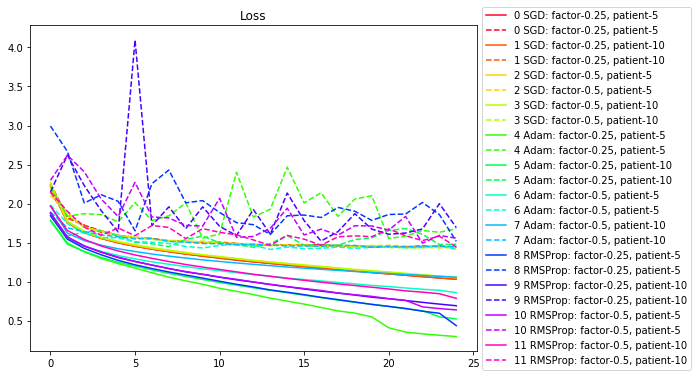

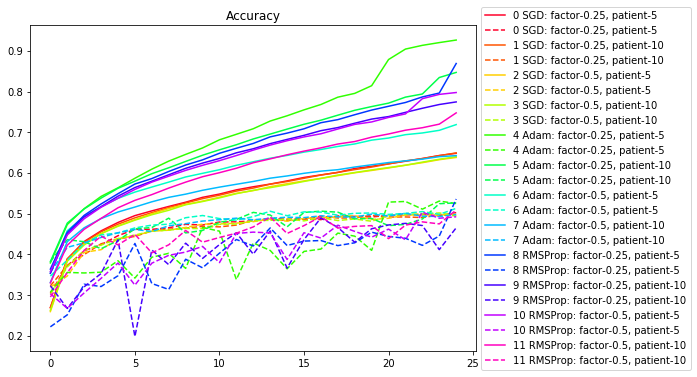

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 結果討論

1. SGD 與 Adam的曲線較平滑，RMSProp的曲線較曲折

2. factor較小(0.25)，learning rate更新速度慢，因此曲線震盪幅度會比factor(0.5)來的大

3. patient較小(5)，learning rate更新較頻繁，較容易達到最佳結果
